In [64]:
import scipy.integrate as integrate
from scipy.integrate import odeint, solve_ivp
import scipy.linalg as la
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, tan, sqrt
import cmath
import sys

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [65]:
Mav = 47500
Mfus = 46266.1
Mnlg = 145.3
Mmlg = 2*544.3
Ifus = 1.6961e6
Dnm = 14.441
d2 = 13.618
d1 = Dnm - d2
Ampl = 0.01
phi = -2*pi*0.441
V = 7.71667
omega = 2*pi*V
#omega = 111.19499981
#omega = 110.14156318
#omega = 2.31929416
#omega = 8.56023595


print(f"Omega : {omega}")

CA1 = 2*13328.
CA2 = 2962.

KA1 = 2*2895316.
KA2 = 46266.1

Km = 2*3891698
Kn = 1732578

Nddl = 4


#Question 1
M = np.array([[Mmlg, 0, 0, 0],
              [0,Mnlg, 0, 0],
              [0,0, Mfus, 0],
              [0, 0, 0, Ifus]])

invM = np.linalg.inv(M)

C = np.array([
    [CA1   ,  0     , -CA1            ,  d1*CA1               ],
    [0     ,  CA2   , -CA2            , -d2*CA2               ],
    [-CA1  , -CA2   ,  CA1 + CA2      ,  d2*CA2 - d1*CA1      ],
    [d1*CA2, -d2*CA2,  d2*CA2 - d1*CA1,  d1**2*CA1 + d2**2*CA2]
])


K = np.array(
    [[KA1 + Km,          0,         -KA1,             d1 * KA1],
     [0         ,          KA2 + Kn,  -KA2,             -d2 * KA2],
     [-KA1      ,           -KA2,      KA1 + KA2,         d2 * KA2 - d1 * KA1],
     [d1 * KA1  ,  -d2 * KA2, d2 * KA2 - d1 * KA1, d2**2 * KA2 + d1**2 * KA1]]
)

F = np.array([Ampl*Km, Ampl*Kn, 0, 0])
Phase = np.array([phi, 0, 0, 0])

Omega : 48.48526756435349


In [66]:
#Valeur propre + vecteurs propres
#freqs nats
#8 schémas, 2 par modes propres
#Réponse du sytème ( 1coubre par ddl)
#Amplitudes max et déphases chaque ddl (0 à 120 rad/s)
# Y superposer les amplitudes de forçages
#g réponse du système à la rafale (4 ddl)

LAMBDA, PHI = la.eig(K, M)
print(f"PHI normalisée (norme euclidienne) {PHI}")


Mm = np.diag(np.diag(PHI.transpose()@M@PHI))
PHI = PHI@np.sqrt(np.linalg.inv(Mm))
print(f"PHI telle que Phit.M.Phi=I {PHI}")

Mm = PHI.transpose()@M@PHI
Cm = PHI.transpose()@C@PHI

Wi = np.sqrt(np.real(LAMBDA))
zeta = np.diag(Cm)/(2*Wi)
Zetai = zeta
Wd = Wi*np.sqrt(1-Wi**2)

Fm = PHI.transpose()*F


PHI normalisée (norme euclidienne) [[ 9.99917481e-01 -1.07955993e-03  3.99283783e-01 -4.81396359e-02]
 [ 7.93951428e-03  9.99999414e-01  1.79275320e-02  2.93697261e-01]
 [-1.00967236e-02 -7.11545130e-05  9.16494669e-01  5.36890216e-01]
 [ 2.26198386e-04 -3.05941922e-05 -1.69878209e-02  7.89413320e-01]]
PHI telle que Phit.M.Phi=I [[ 3.02418133e-02 -8.95590724e-05  2.00838288e-03 -4.65314787e-05]
 [ 2.40125123e-04  8.29588216e-02  9.01748325e-05  2.83885983e-04]
 [-3.05368430e-04 -5.90289800e-06  4.60993479e-03  5.18954811e-04]
 [ 6.84121388e-06 -2.53805962e-06 -8.54481202e-05  7.63042104e-04]]


C:\Users\colin\AppData\Local\Temp\ipykernel_9960\4257348798.py:23: RuntimeWarning: invalid value encountered in sqrt
  Wd = Wi*np.sqrt(1-Wi**2)


In [67]:
n = 40001

t = np.linspace(0,100, n)
z0 = np.zeros(2*Nddl)

x = np.zeros((n, Nddl))
y = np.zeros((n, Nddl))

u = np.zeros((n, Nddl))
for i in range(n):
    u[i][:] = F[:]*np.cos(omega*t[i] + Phase[:])

for i in range(Nddl):
    x[0][i] = z0[2*i]
    y[0][i] = z0[2*i + 1]

def model(z, t, u, invm, c, k, n):
    xl = np.zeros(n)
    yl = np.zeros(n)
    dzdt = np.zeros(2*n)
    for i in range(n):
        xl[i] = z[2*i]
        yl[i] = z[2*i + 1]

    dxdt = yl
    dydt = invm @ (-c @ yl - k @ xl + u)
    for i in range(n):
        dzdt[2*i] = dxdt[i]
        dzdt[2*i + 1] = dydt[i]
    return dzdt

In [68]:

for i in range(1, n):
    tspan = [t[i-1], t[i]]

    z = odeint(model, z0, tspan, args = (u[i][:], invM, C, K, Nddl))

    for j in range(Nddl):
        x[i,j] = z[1, 2*j]
        y[i,j] = z[1, 2*j + 1]


    z0[:] = z[1, :]

Amax = np.zeros(Nddl)
for i in range(Nddl):
    print("Valeur max. en régime permanent : ", np.amax(x[int(n/2):, i]))
    Amax[i] = np.amax(x[int(n/2):, i])


Valeur max. en régime permanent :  0.006815576201159262
Valeur max. en régime permanent :  0.011988453550009274
Valeur max. en régime permanent :  0.00038253038095142894
Valeur max. en régime permanent :  1.3404572872719749e-05


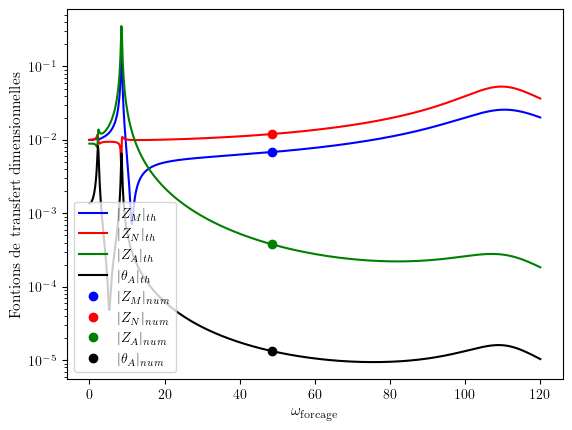

In [69]:
#1f

n_points = 1000
w = np.linspace(0, 120, n_points)
A = np.zeros((n_points, Nddl))

dephasage = np.zeros((n_points, Nddl))

for i in range(n_points):
    A[i,:]=abs(np.linalg.inv(K-w[i]*w[i]*M+1j*w[i]*C)@(F[:]*np.exp(1j*Phase[:])))
    dephasage[1,:]=np.angle(np.linalg.inv(K-w[i]*w[i]*M+1j*w[i]*C)@(F[:]*np.exp(1j*Phase[:])))


# plot des amplitudes en fonction de la fréquence de forçage
plt.semilogy(w, A[:,0], 'b-', label=r'$|Z_M|_{th}$')
plt.semilogy(w, A[:,1], 'r-', label=r'$|Z_N|_{th}$')
plt.semilogy(w, A[:,2], 'g-', label=r'$|Z_A|_{th}$')
plt.semilogy(w, A[:,3], 'k-', label=r'$|\theta_A|_{th}$')
plt.semilogy(omega, Amax[0], 'ob', label=r'$|Z_M|_{num}$')
plt.semilogy(omega, Amax[1], 'or', label=r'$|Z_N|_{num}$')
plt.semilogy(omega, Amax[2], 'og', label=r'$|Z_A|_{num}$')
plt.semilogy(omega, Amax[3], 'ok', label=r'$|\theta_A|_{num}$')
plt.xlabel(r'$\omega_\mathrm{forcage}$', fontsize=11)
plt.ylabel(r'Fontions de transfert dimensionnelles', fontsize=11)
plt.legend(loc='best')
plt.savefig('amp_f_transfert.png', dpi = 300, bbox_inches = 'tight')
plt.show()


In [70]:
R = np.block([
    [np.zeros((Nddl,Nddl)), K ],
    [K, C],
])
S = np.block([
    [-K, np.zeros((Nddl, Nddl))],
    [np.zeros((Nddl,Nddl)),M]
])
print( "R et S", R, S)

lamdag, phig = la.eig(R,S)
print(f"Lambda, amortissement général (valeurs propores) : {lamdag}")
print(f"PHI, Amortissement Général normalisée (norme euclidienne) {phig}")

#À vérifier, je doute bcp de zeta
Wn = np.sqrt(abs(lamdag))
zeta = np.real(lamdag)
Wd2 = Wn*np.sqrt(1-zeta**2)


# print("Matrices Abaissement d'ordre")
RD = phig.transpose()@R@phig
SD = phig.transpose()@S@phig
PHIBG=phig@np.sqrt(np.linalg.inv(SD))
SDun = PHIBG.transpose()@S@PHIBG
RDlambda = PHIBG.transpose()@R@PHIBG
# print(np.diag(RD))
print('S identité')
print(SDun)
print('R Lambda')
print(RDlambda)
print('PHI Tilde')
print(PHIBG)
print("RD lambda")
print(RDlambda)



invSD = np.linalg.inv(SDun)
# number of time points
n = 50001
# time points
t = np.linspace(0,50,n)
# initial condition
zd0 = np.zeros((2*Nddl), dtype=np.complex128)
# storage
rd = np.zeros((n,2*Nddl),dtype=np.complex128)
q = np.zeros((n,2*Nddl),dtype=np.complex128)
# Forcing term
zero = [0,0,0,0]
FU = np.concatenate((zero, F[:]*np.exp(1.j*(Phase[:]))),axis=None)
FD = PHIBG.transpose()@FU

# record initial conditions
rd[0,:] = zd0[:]
# function that returns dz/dt
def modelc(tt, zz, invSS, RR, FR):
    u = np.zeros((2*Nddl), dtype=np.complex128)
    u[:] = FR[:]*np.exp(1.j*omega*tt)
    dzdt = invSS @ (-RR@zz+u)
    return dzdt
tspan = [t[0], t[n-1]]
z = solve_ivp(modelc, tspan, zd0, method='RK45', args=(invSD,RDlambda,FD),t_eval=t[0:n-1])
rd=z.y.transpose()
for i in range(n-1):
    q[i,:] = PHIBG@rd[i,:]

R et S [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.35740280e+07  0.00000000e+00 -5.79063200e+06  4.76569014e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.77884410e+06 -4.62661000e+04 -6.30051750e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.79063200e+06 -4.62661000e+04  5.83689810e+06 -4.13563839e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.76569014e+06 -6.30051750e+05 -4.13563839e+06  1.25022077e+07]
 [ 1.35740280e+07  0.00000000e+00 -5.79063200e+06  4.76569014e+06
   2.66560000e+04  0.00000000e+00 -2.66560000e+04  2.19378880e+04]
 [ 0.00000000e+00  1.77884410e+06 -4.62661000e+04 -6.30051750e+05
   0.00000000e+00  2.96200000e+03 -2.96200000e+03 -4.03365160e+04]
 [-5.79063200e+06 -4.62661000e+04  5.83689810e+06 -4.13563839e+06
  -2.66560000e+04 -2.96200000e+03  2.96180000e+04  1.83986280e+04]
 [ 4.76569014e+06 -6.30051750e+05 -4.13563839e+06  1.25022077e

C:\Users\colin\AppData\Local\Temp\ipykernel_9960\3188702212.py:18: RuntimeWarning: invalid value encountered in sqrt
  Wd2 = Wn*np.sqrt(1-zeta**2)


In [ ]:
def plot_rep1e():   
    plt.rc('text', usetex=False)
    plt.plot(t[0:n], np.real(q[:,0]), 'b-', linewidth=0.5,label=r'$Z_M$')
    plt.plot(t[0:n], np.real(q[:,1]), 'r-', linewidth=0.5,label=r'$Z_N$')
    plt.plot(t[0:n], np.real(q[:,2]), 'g-', linewidth=0.5,label=r'$Z_A$')
    plt.plot(t[0:n], np.real(q[:,3]), 'k-', linewidth=0.5,label=r'$\theta_A$')
    plt.xlabel(r't (s)', fontsize=11)
    plt.xlim([0, 2])
    plt.ylabel(r'Déplacement (m)', fontsize=11)
    plt.legend(loc='best')
    plt.savefig('reponse_forcee_physique.png', dpi = 300, bbox_inches='tight')
    plt.show()

    plt.rc('text', usetex=False)
    plt.plot(t[0:n], np.real(q[:,0]), 'b-', linewidth=0.5,label=r'$Z_M$')
    plt.plot(t[0:n], np.real(q[:,1]), 'r-', linewidth=0.5,label=r'$Z_N$')
    plt.plot(t[0:n], np.real(q[:,2]), 'g-', linewidth=0.5,label=r'$Z_A$')
    plt.plot(t[0:n], np.real(q[:,3]), 'k-', linewidth=0.5,label=r'$\theta_A$')
    plt.xlabel(r't (s)', fontsize=11)
    plt.xlim([2, 15])
    plt.ylabel(r'Déplacement (m)', fontsize=11)
    plt.legend(loc='best')
    plt.savefig('reponse_forcee_physique.png', dpi = 300, bbox_inches='tight')
    plt.show()

Lambda : [1.25239549e+04+0.j 1.22427162e+04+0.j 7.32691885e+01+0.j
 5.40326622e+00+0.j], Phi [[ 3.02418133e-02 -8.95590724e-05  2.00838288e-03 -4.65314787e-05]
 [ 2.40125123e-04  8.29588216e-02  9.01748325e-05  2.83885983e-04]
 [-3.05368430e-04 -5.90289800e-06  4.60993479e-03  5.18954811e-04]
 [ 6.84121388e-06 -2.53805962e-06 -8.54481202e-05  7.63042104e-04]]
 Wi : [111.91047722 110.64680849   8.55974232   2.32449268], 
 Zeta : [0.11115699 0.09220808 0.01325999 0.07211306] 
 Wd = [nan nan nan nan]


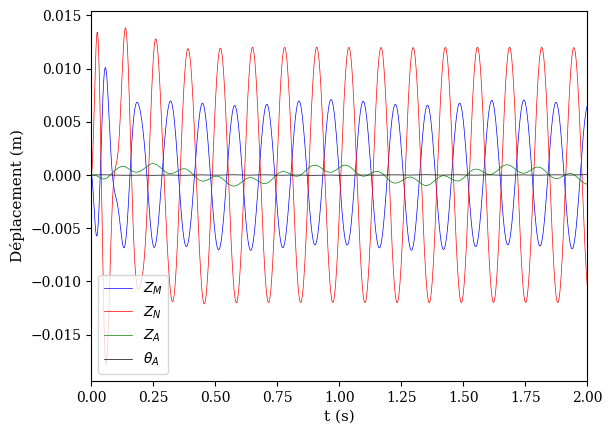

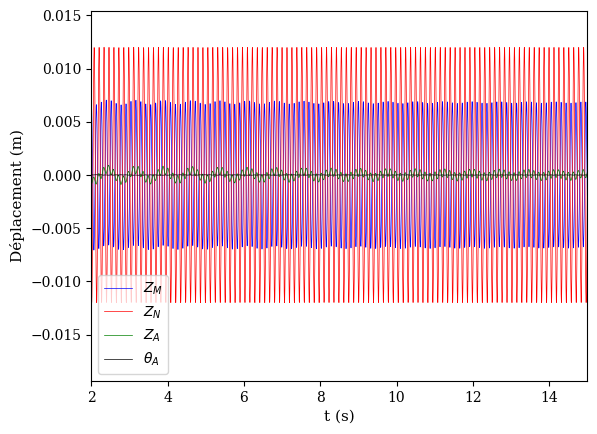

 Wn : [10.57777963 10.57777963 10.51727765 10.51727765  2.92593932  2.92593932
  1.52488147  1.52488147], 
 Zeta : [12.43963139 12.43963139 10.20240223 10.20240223  0.1135221   0.1135221
  0.16773398  0.16773398] 
 Wd = [      nan       nan       nan       nan 2.9070245 2.9070245 1.5032774
 1.5032774]


In [ ]:
#1b
print(f"Lambda : {LAMBDA},\n Phi {PHI}")
#1c
print(f" Wi : {Wi}, \n Zeta : {Zetai} \n Wd = {Wd}")
#Plug les 8 schémas (2 par mode propres)
#1e
plot_rep1e()
print(f" Wn : {Wn}, \n Zeta : {zeta} \n Wd = {Wd2}")